In [1]:
#imprt the necessary calculations for everything we will use
import datetime
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy.ndimage import gaussian_filter
from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import xlrd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import linregress

In [2]:
#blue marble pathway
os.environ["CARTOPY_USER_BACKGROUNDS"] = '/Users/cjmasiel/Desktop/Cartopy/BG/'

In [128]:
#this is the function that creates the map background of the North Atlantic Domain
def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig=plt.figure(figsize=(25, 25))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([-10, -105, 5, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([0,-10, -20,-30, -40,-50, -60,-70, -80,-90,-100,-110])
    gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ###############################################################################################
    ax.background_img(name='BM', resolution='high')
    ###############################################################################################
    plt.scatter(-180,-40,alpha = 1.0, color = '#5ebaff', label = 'Tropical Depression')
    plt.scatter(-180,-40,alpha = 1.0, color='#00faf4', label = 'Tropical Storm')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffffcc', label = 'Category 1')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffe775', label = 'Category 2')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffc140', label = 'Category 3')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff8f20', label = 'Category 4')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff6060', label = 'Category 5')
    plt.legend(loc = 'upper left')
    return fig, ax

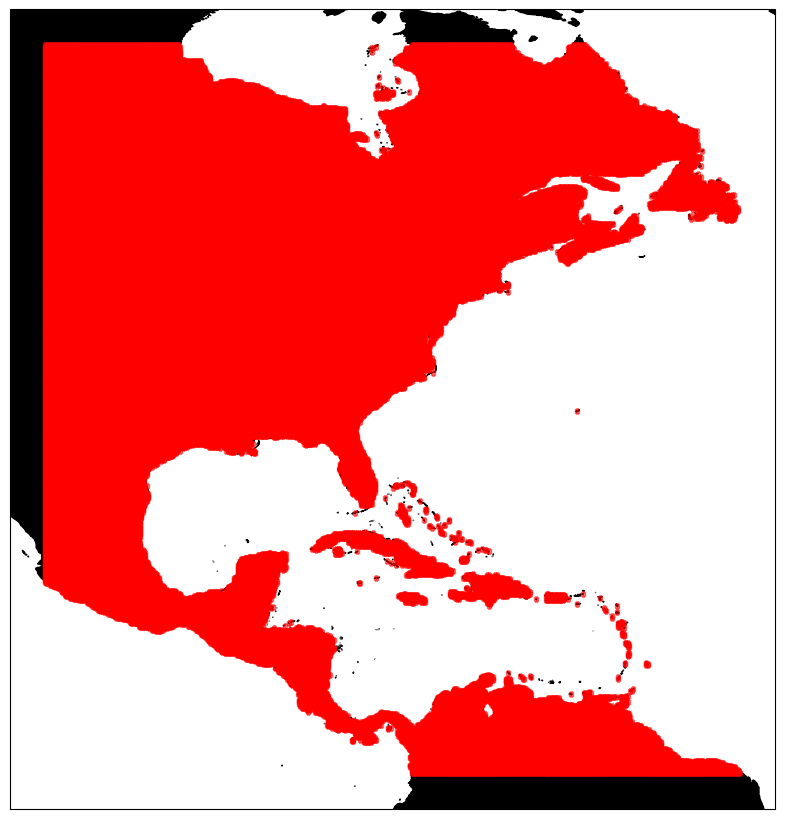

In [4]:
from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import cartopy
from shapely.prepared import prep
import seaborn as sns


land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

lats = np.arange(5, 60, 0.1)
lons = np.arange(-105, -50, 0.1)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]


land = []
for land_polygon in land_polygons_prep:
    land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor=sns.xkcd_rgb['black'])

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),s=12, marker='s', c='red', alpha=0.5, zorder=2)

In [5]:
# Round each element in xs and ys to the nearest decimal
rounded_xs = [round(x, 1) for x in xs]  # Round to one decimal place
rounded_ys = [round(y, 1) for y in ys]  # Round to one decimal place

In [6]:
#so, now that we have the rounded values of xs and ys, we now need to compare the values of the center of storms
#of interest to this list

#next, we parse through the Hurdat dataset to get the years of interest, to start off we will look
#at just one year to make sure it is doing what I think it is 

#This is the list of unique storms I want to consider\n
CODE = []

with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            year = float(values[0][4:8])
            for i in range(1980,2023):
                if year == i:
                    code = values[0]
                    CODE.append(code)
        else:
            lines_to_read -=1 

In [7]:
#Now that we have the storms we are interested in looking, we will loop through the same list as before\n",
#However, this time we will have a bunch of logical \n",

VMAX      = []
LAT       = []
LON       = []
CODE_calc = []
PRES      = []
TIME      = []

with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            value_lines_to_read = int(values[2]) 
            code = str(values[0])
        else:
            latitude  = float(values[4][:-1])
            longitude = -1 * float(values[5][:-1])
            vmax      = float(values[6])
            nature    = str(values[3])
            time      = str(values[1])
            pressure  = str(values[7])
            for i in CODE:
                if code == i:        #Just looking to see if the AL number is equal to the one in our list\n",
                    if time not in (' 0000', ' 0600', ' 1200', ' 1800'):
                        #print("Do not Consider, " "Storm =", code, "time =", time)
                        continue
                    elif nature in (' TD', ' TS', ' HU'):
                        VMAX.append(vmax)
                        LAT.append(latitude)
                        LON.append(longitude)
                        CODE_calc.append(code)   
                        PRES.append(pressure)
            #now we continue parsing through our data set
            lines_to_read -=1 


print("Length of number of Storms appended = ", len(CODE_calc))
print("Length of intensity list = ", len(VMAX))

Length of number of Storms appended =  14687
Length of intensity list =  14687


In [8]:
#now, we must compare the lat and longitude index points to the mask lat lon values
LAND_LAT = []
LAND_LON = []
LAND_VMAX = []
LAND_CODE = []
LAND_PRES = []

for i in range(len(LAT)):
    for j in range(len(rounded_xs)):
        if (LON[i],LAT[i]) == (rounded_xs[j],rounded_ys[j]):
            LAND_LAT.append(LAT[i])
            LAND_LON.append(LON[i])
            LAND_VMAX.append(VMAX[i])
            LAND_CODE.append(CODE_calc[i])
            LAND_PRES.append(PRES[i])
            
print("length of LAND_LAT =", len(LAND_LAT))

length of LAND_LAT = 1372


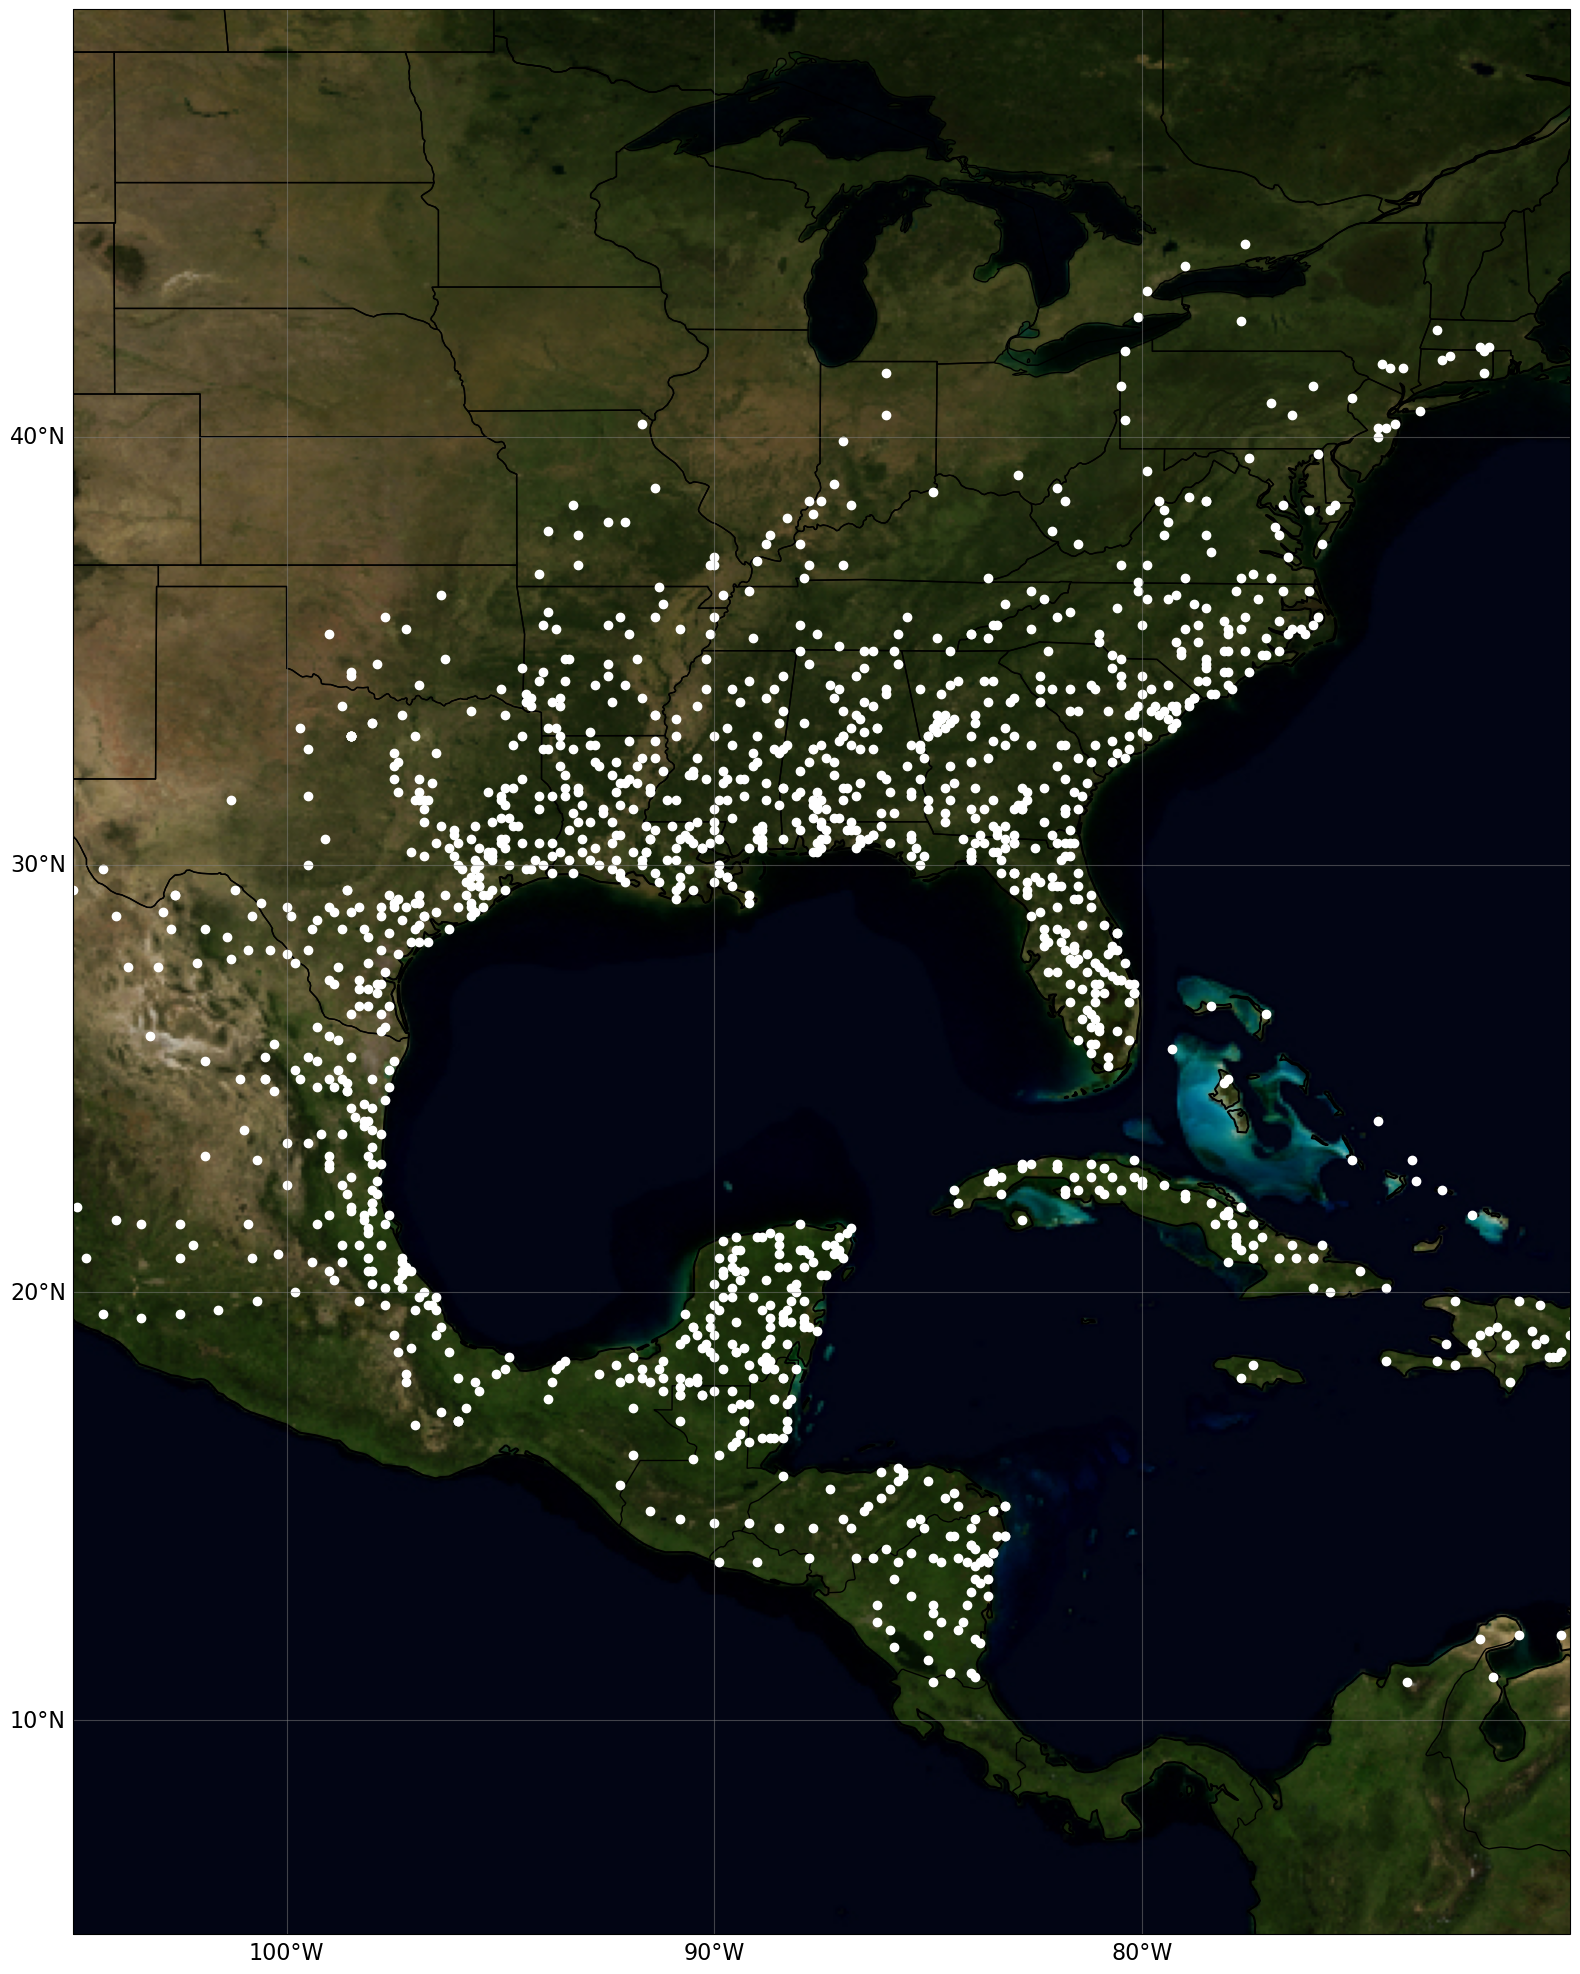

In [11]:
fig, ax = create_map_background()

plt.scatter(LAND_LON, LAND_LAT, color = 'white',zorder=2)

In [12]:
unique_code = set(LAND_CODE)

In [13]:
def plotstorm(a,b,c,d,e,f,g,x):
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []
    
    Latorigin = []
    Longorigin = []
    
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm1.append(lat_strm)
            LongStorm1.append(lon_strm)
            if first_match:
                Latorigin.append(lat_strm)
                Longorigin.append(lon_strm)
                first_match = False
   
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x:
            if vmax < 34:
                Lat.append(latitude)
                Long.append(longitude)
            if 34 <= vmax < 63:
                LatStorm.append(latitude)
                LongStorm.append(longitude)
            if 63 < vmax <= 83:
                Lat1.append(latitude)
                Long1.append(longitude)
            if 83 < vmax <= 95:
                Lat2.append(latitude)
                Long2.append(longitude)
            if 95 < vmax <= 112:
                Lat3.append(latitude)
                Long3.append(longitude)
            if 112 < vmax <= 136:
                Lat4.append(latitude)
                Long4.append(longitude)
            if vmax > 136:
                Lat5.append(latitude)
                Long5.append(longitude)


    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff', label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4', label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)
    
    plt.scatter(Longorigin,Latorigin, alpha = 1.0, color='white', marker = 'v',zorder=10)

    plt.title('1980-2022 North Atlantic Landfalling Tropical Cyclones',{"fontsize": 20}, loc = 'left')
    plt.title('Product by: Cameron Masiello',{"fontsize": 20}, loc = 'right')

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


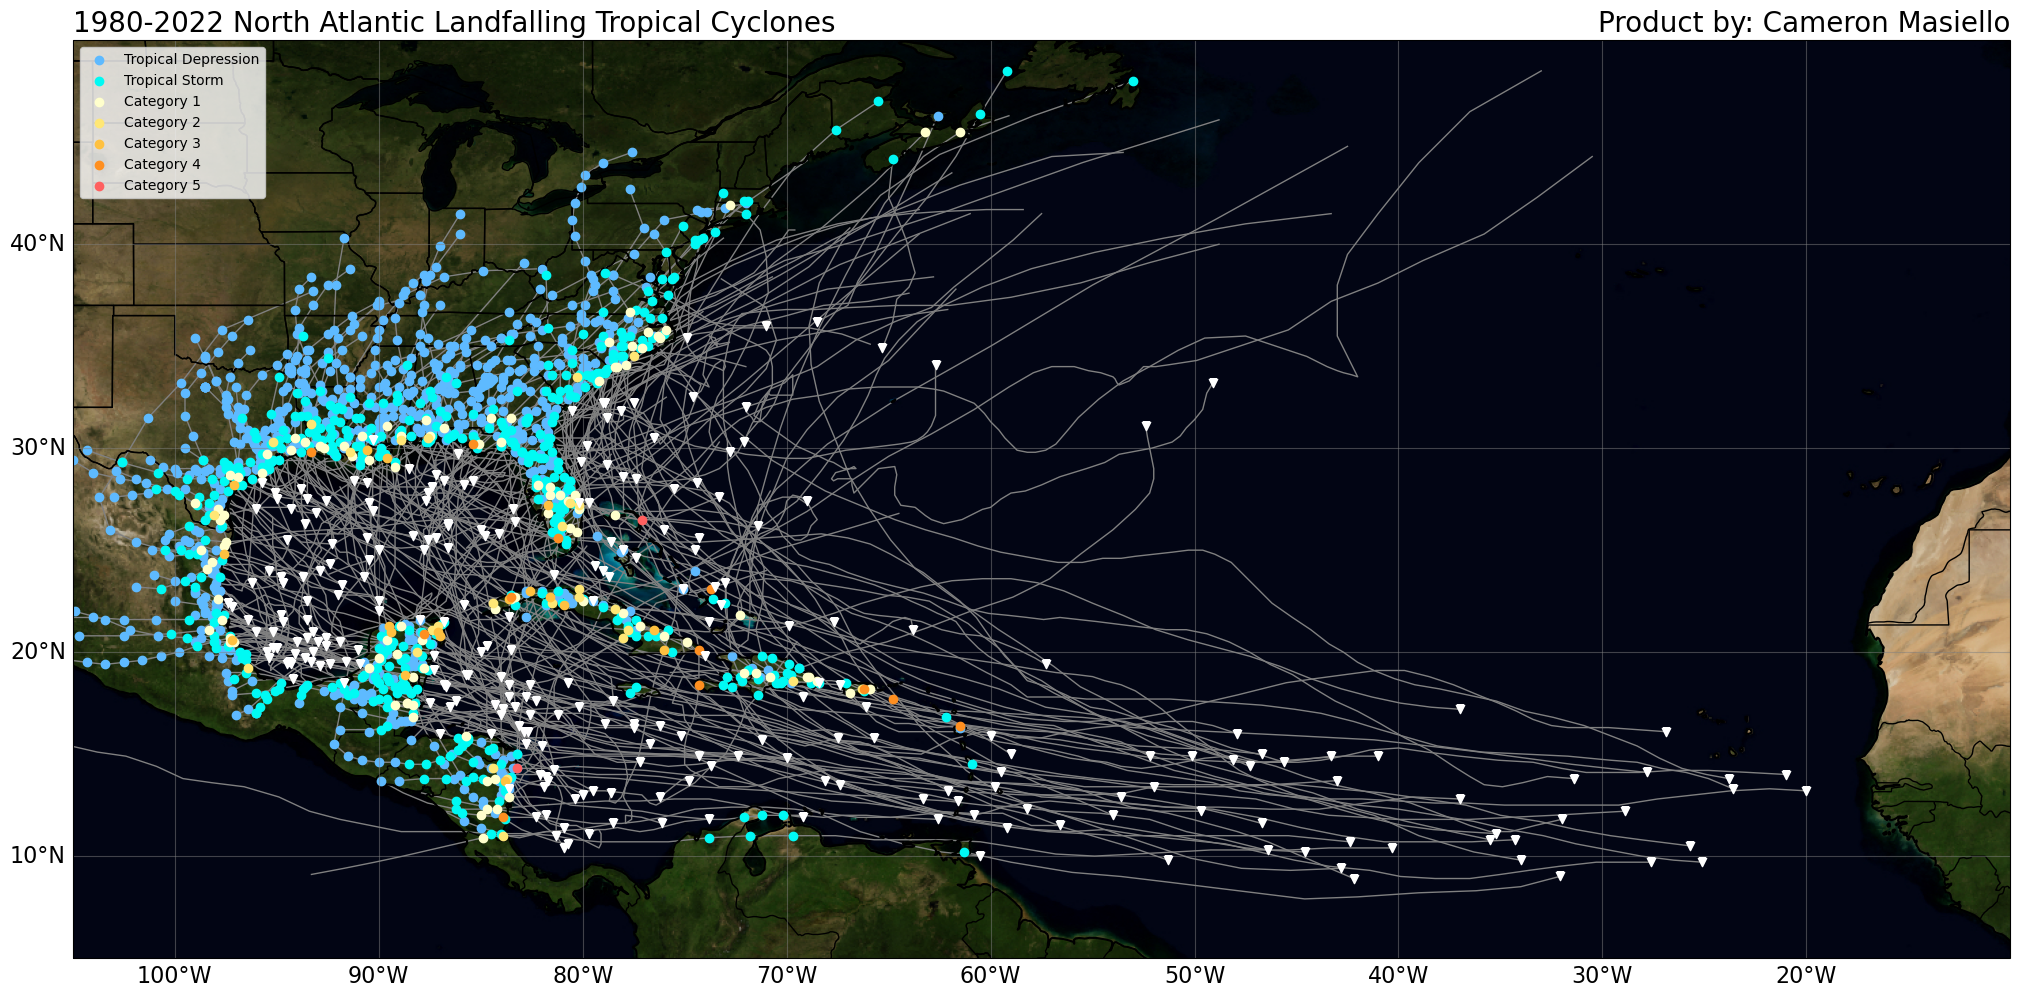

In [129]:
fig, ax = create_map_background()

for item in unique_code:
    plotstorm(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item)

In [17]:
#now, lets see where the majority of storms track that make landfall in the NATL
LatStorm1 = []
LongStorm1 = []

Latorigin = []
Longorigin = []

for item in unique_code:
    first_match = True
    for i in range(len(LON)):
        lon_strm   = LON[i]
        lat_strm   = LAT[i]
        code_strm  = CODE_calc[i]
        if code_strm == item:
            LatStorm1.append(lat_strm)
            LongStorm1.append(lon_strm)
            if first_match:
                Latorigin.append(lat_strm)
                Longorigin.append(lon_strm)
                first_match = False

In [27]:
#Next, I want to look at the location of hurricanes and all Tropical Storms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the base color as '#00faf4'
base_color = 'red'

# Define the number of steps in the color scale
num_steps = 20

# Create a linearly spaced array of alpha values from 0 to 1\n",
alphas = np.linspace(0, 1, num_steps)

# Create a list of colors with varying alpha values\n",
colors = [mcolors.to_rgba(base_color, alpha=a) for a in alphas]

# Create a color map using the list of colors
cmap_new = mcolors.ListedColormap(colors)

def RIdinsity(x,y,z):
    plt.title('Center Location of Landfalling Tropical Cyclones in the NATL (1980-2022)', {"fontsize": 16}, loc = 'left')
    plt.title(f'Product By: Cameron Masiello \n Lanfalling Storms ={len(z)}', {"fontsize": 12}, loc = 'Right')
    plot = plt.hist2d(x, y, bins=[list(range(-110, -10)), list(range(5, 50))], cmap=cmap_new)
    plt.clim(0,20)
    cbar = plt.colorbar(orientation = 'horizontal', pad = .05, shrink = 1, aspect = 50, extend = 'both')
    cbar.ax.set_xlabel('1 x 1 Degree Density', fontsize = 20)

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


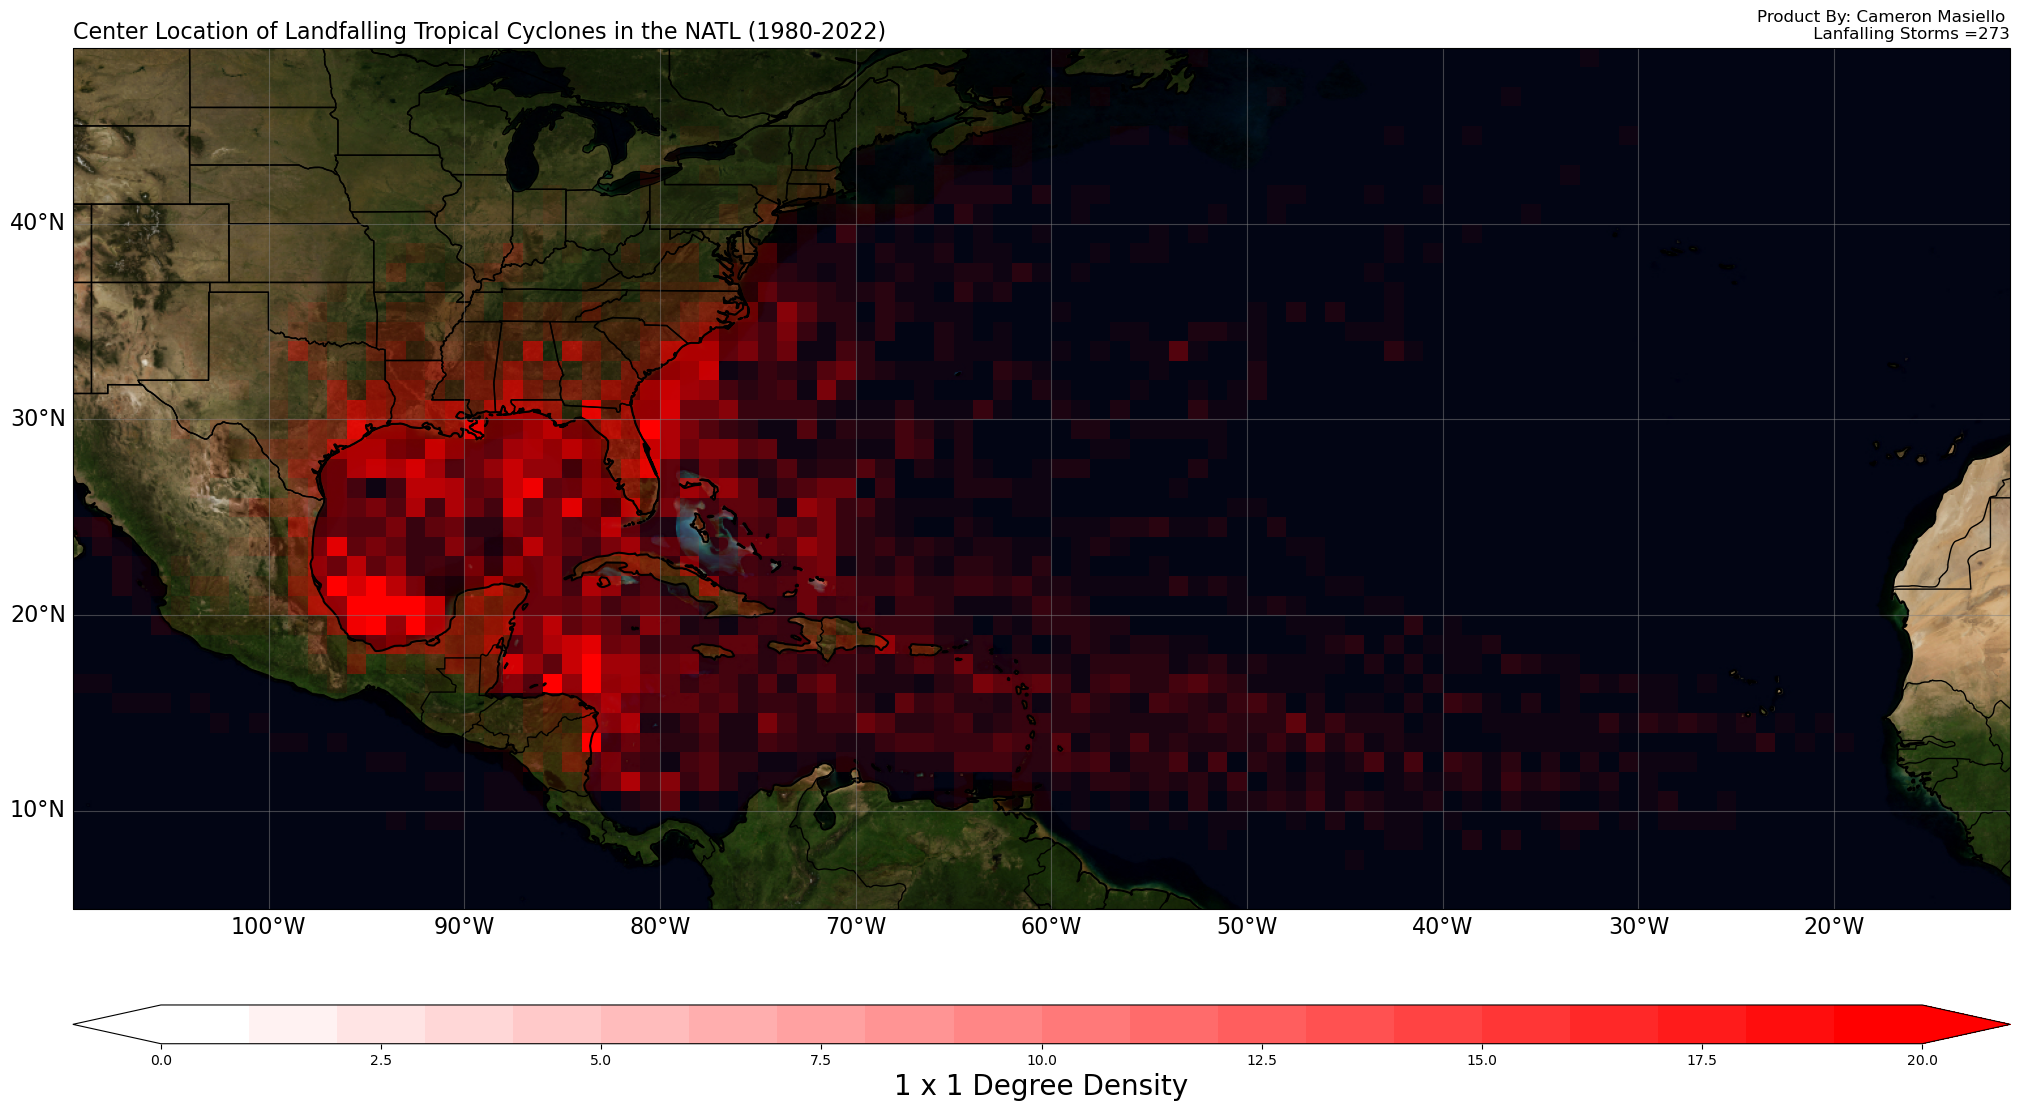

In [29]:
fig, ax = create_map_background()

RIdinsity(LongStorm1, LatStorm1, unique_code)

In [30]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Here we are making a new color scale for landfalling information
def Color_Scale_Landfall():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/137, '#5ebaff'),
    (34/137, '#00faf4'),
    (64/137, '#ffffcc'),
    (83/137, '#ffe775'),
    (96/137, '#ffc140'),
    (113/137, '#ff8f20'),
    (137/137, '#ff6060')])

    return newcmp

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(1.0, 1.0, 'Product By: Cameron Masiello \n NUMBER OF CASES = 14687')

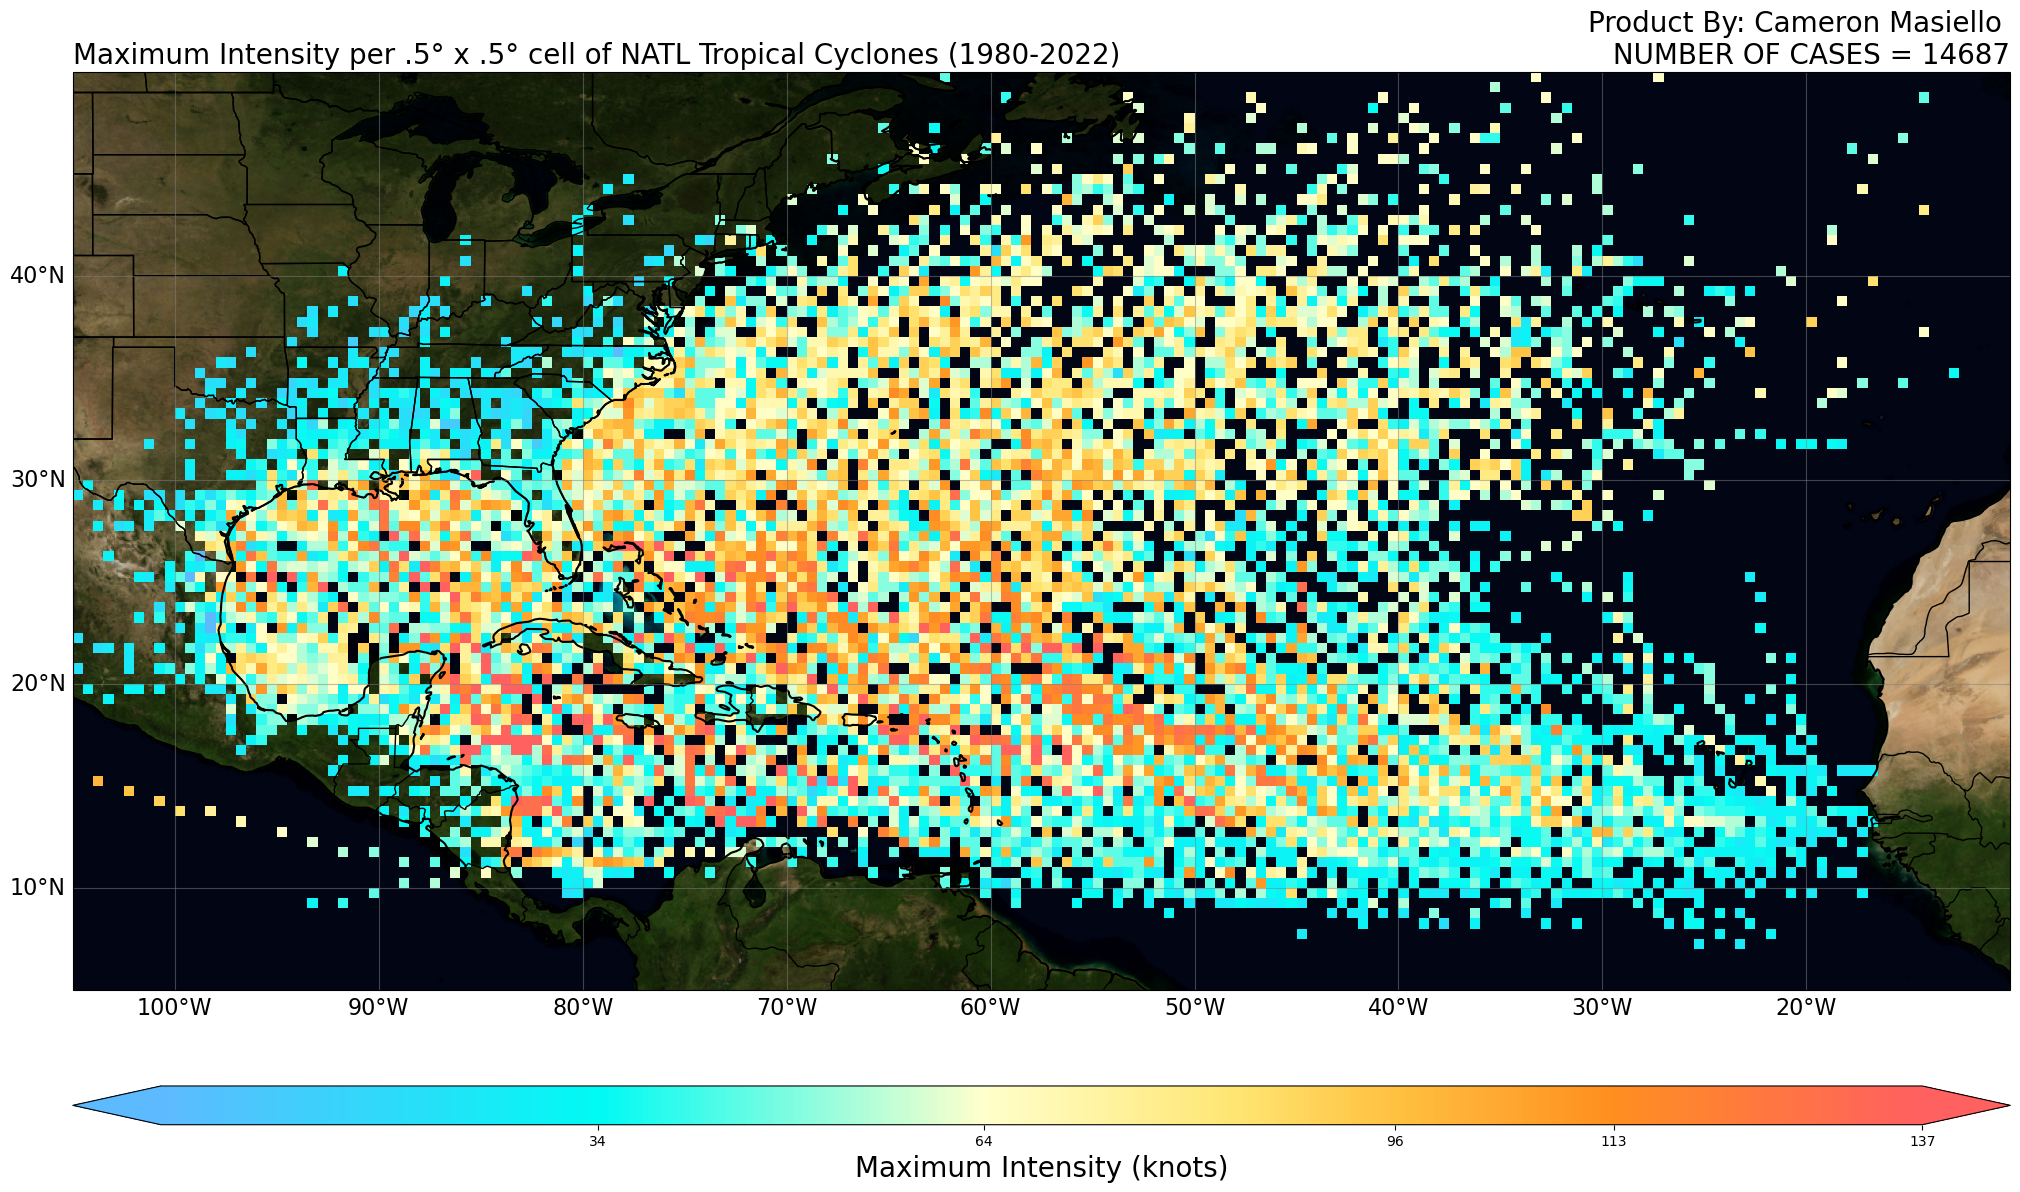

In [31]:
#Now, let us calcualte the maxmimum intensity of grid cells in the two time frames:
#this cell will plot the average intensity at landfall from 1980-2022
fig, ax = create_map_background()

# Assuming you have lon_6, lat_6, and intensity_change_6 as your data arrays
#xedges = list(range(-110, -10))
#yedges = list(range(0, 50))

xedges = [x / 10 for x in range(-2200, -100, 5)]
yedges = [y / 10 for y in range(0, 1000, 5)]

counts, _, _ = np.histogram2d(LON, LAT, bins=[xedges, yedges])

# Create an empty array to store the maximum intensity for each grid cell
max_intensity = np.full((len(yedges) - 1, len(xedges) - 1), np.nan)

# Convert your lists to NumPy arrays
LON = np.array(LON)
LAT = np.array(LAT)

for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        lon_mask = (LON >= xedges[i]) & (LON < xedges[i + 1])
        lat_mask = (LAT >= yedges[j]) & (LAT < yedges[j + 1])
        cell_mask = lon_mask & lat_mask

        if np.any(cell_mask):
            max_intensity[j, i] = np.max(np.array(VMAX)[cell_mask])

# Tranpose our data to get it into the form that is useful
max_intensity_n = max_intensity

# Create the plot using the custom colormap and bounds
plt.pcolormesh(xedges, yedges, max_intensity_n, cmap=Color_Scale_Landfall(), vmin=0, vmax=137)

# Create a color bar with custom boundaries and labels
cbar = plt.colorbar(orientation='horizontal', pad=0.05, shrink=1, aspect=50, extend='both')

# Set the tick locations
cbar.set_ticks([34, 64, 96, 113, 137])

# Set the tick labels
cbar.set_ticklabels([34, 64, 96, 113, 137])

cbar.ax.set_xlabel('Maximum Intensity (knots)', fontsize=20)

# Add labels and title
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Maximum Intensity per .5° x .5° cell of NATL Tropical Cyclones (1980-2022)', fontsize=20, loc='left')
plt.title(f'Product By: Cameron Masiello \n NUMBER OF CASES = {len(LAT)}', fontsize=20, loc='right')

In [49]:
def find_consecutive_sublists(lst1, lst2):
    # A helper function to check if a sublist exists in another list
    def is_sublist(sub, lst):
        for i in range(len(lst) - len(sub) + 1):
            if lst[i:i+len(sub)] == sub:
                return True
        return False

    consecutive_sets = []
    skipped_indices = __builtins__.set()

    for i in range(len(lst1)):
        if i in skipped_indices:
            continue
        for j in range(len(lst1), i, -1):
            sublist = lst1[i:j]
            if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                consecutive_sets.append(sublist)
                skipped_indices.update(range(i, j))
                break

    return consecutive_sets

lst1 = [5, 4, 6, 7, 10, 10, 10, 1]
lst2 = [5, 4, 6, 7, 9, 9, 9, 10, 10, 10, 1]

result = find_consecutive_sublists(lst1, lst2)
print(result)  # [[5, 4, 6, 7], [10, 10, 10, 1]]

[[5, 4, 6, 7], [10, 10, 10, 1]]


In [102]:
def Wind_Decay_new(a,b,c,d,e,f,g,x):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    current_velocity.append(vmax)
                    break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time = []

    for sublist in velocity:
        # Create a new sublist for this part of the velocity
        current_time = [(j * 6) for j in range(len(sublist))]

        # Append the current sublist to the main time list
        time.append(current_time)

    #Below is the plotting code \n",
    for i in range(len(velocity)):
        #print("Velocity list =", velocity[i], "Time list =", time[i])
        plt.plot(time[i], velocity[i], "-o", color = 'black')

        plt.title('1980-2022 North Atlantic US Landfalling Tropical Cyclones',{"fontsize": 12}, loc = 'left')
        plt.title('Product by: Cameron Masiello',{"fontsize": 12}, loc = 'right')

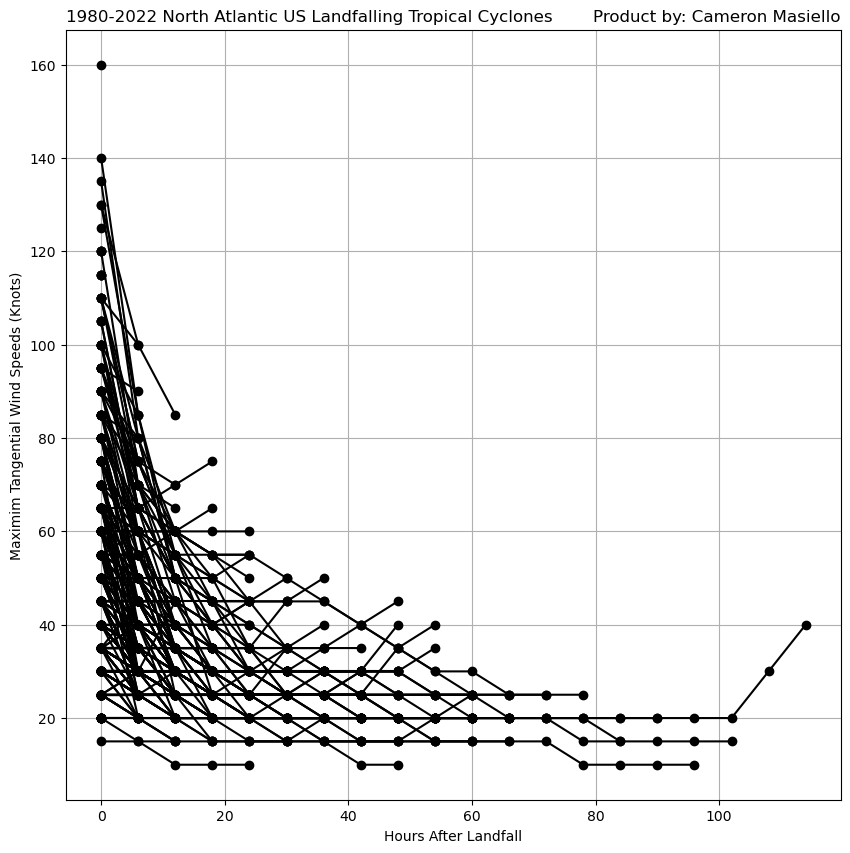

In [103]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.ylabel('Maximim Tangential Wind Speeds (Knots)')
plt.xlabel('Hours After Landfall')

for item in unique_code:
    Wind_Decay_new(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item)

In [117]:
all_tau_n = []
all_v_n = []

In [118]:
#now, lets calcualte 6,12,18,and 24 hour tau as a funciton of Landfall Intensity, the value of tau will
#be on the x-axis, Maximum Tangential winds will be on the x-axis

def Wind_Decay_new_tau(a,b,c,d,e,f,g,x):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)
            
#     #create a function to determine if the lists have unique elements
#     def are_elements_consecutive(list1, list2):
#         if not list2:
#             return False
        
#         consecutive_count = 0
        
#         for item in list1:
#             if item == list2[consecutive_count]:
#                 consecutive_count += 1
#                 if consecutive_count == len(list2):
#                     return True
#             else:
#                 consecutive_count = 0
#         return False
    
#     #now, we will use this list to parse through our velocity fields
#     if are_elements_consecutive(LatStorm, LatLand) == True:
#         for i in range(len(a)):
#             vmax = d[i]
#             code = a[i]
#             if code == x and vmax > 0:
#                 velocity.append(vmax)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    current_velocity.append(vmax)
                    break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time = []

    for sublist in velocity:
        # Create a new sublist for this part of the velocity
        current_time = [(j * 6) for j in range(len(sublist))]

        # Append the current sublist to the main time list
        time.append(current_time)
    
    #How do we calculate tau? we plot ln(v(t)/v(0)) vs time, and then take the best-linear-fit-line to the
    #data points for the first 24 hours
    
    for i in range(len(velocity)):     
        #First create the lists we are going to append to to conduct our calculations
        y_list = []
        x_list = []
        
        v = velocity[i]
        if len(v) >= 5:
            for j in range(0,5):
                t = j * 6
                y_value = np.log(v[j]/v[0])
                y_list.append(y_value)
                x_list.append(t)
        
        if len(v) >= 5:
        #calculate the linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x_list, y_list)

            plt.plot(x_list, y_list, "o", color = 'black')
        
            tau_n = -(1/slope)
            all_tau_n.append(tau_n)
            all_v_n.append(v[0])

            #plot the linear regression
            regression_line = [slope*xi + intercept for xi in x_list]
            plt.plot(x_list,regression_line, color = 'red', label = 'linear_regresssion')

            plt.title('1980-2022 North Atlantic US Landfalling Tropical Cyclones',{"fontsize": 12}, loc = 'left')
            plt.title('Product by: Cameron Masiello',{"fontsize": 12}, loc = 'right')   

/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_69901/246441474.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  tau_n = -(1/slope)


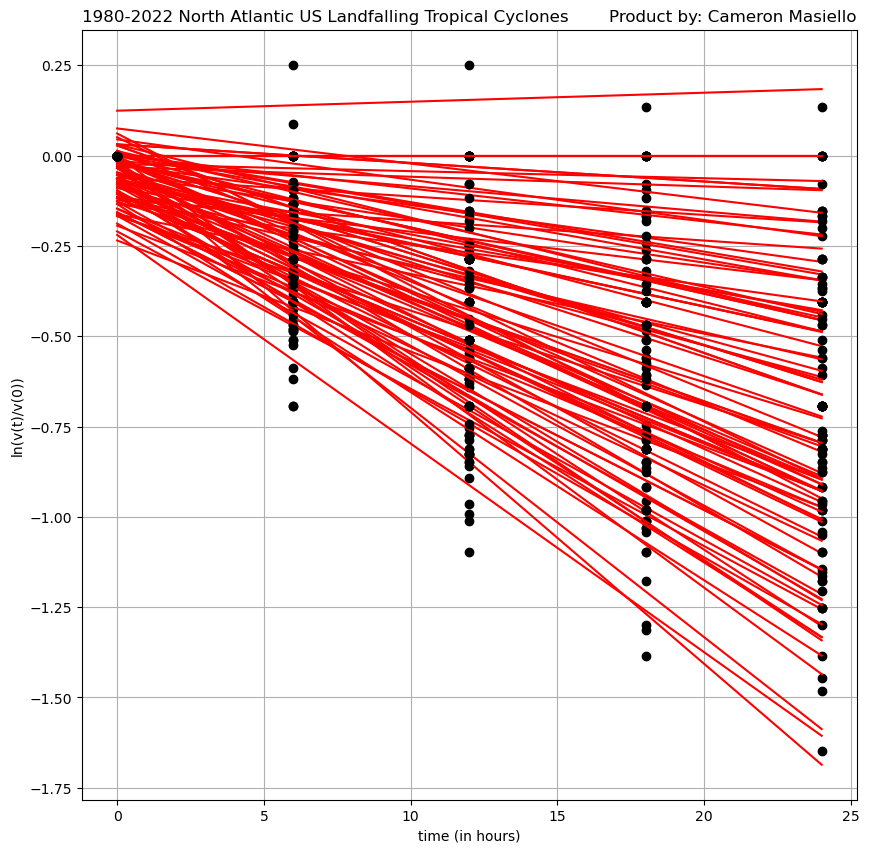

In [119]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('time (in hours)')
plt.ylabel('ln(v(t)/v(0))')
#plt.ylim(0,70)

for item in unique_code:
    Wind_Decay_new_tau(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item)

In [120]:
all_v_pos = []
all_t_pos = []
for i in range(len(all_tau_n)):
    if all_tau_n[i] >=0:
        all_v_pos.append(all_v_n[i])
        all_t_pos.append(all_tau_n[i])

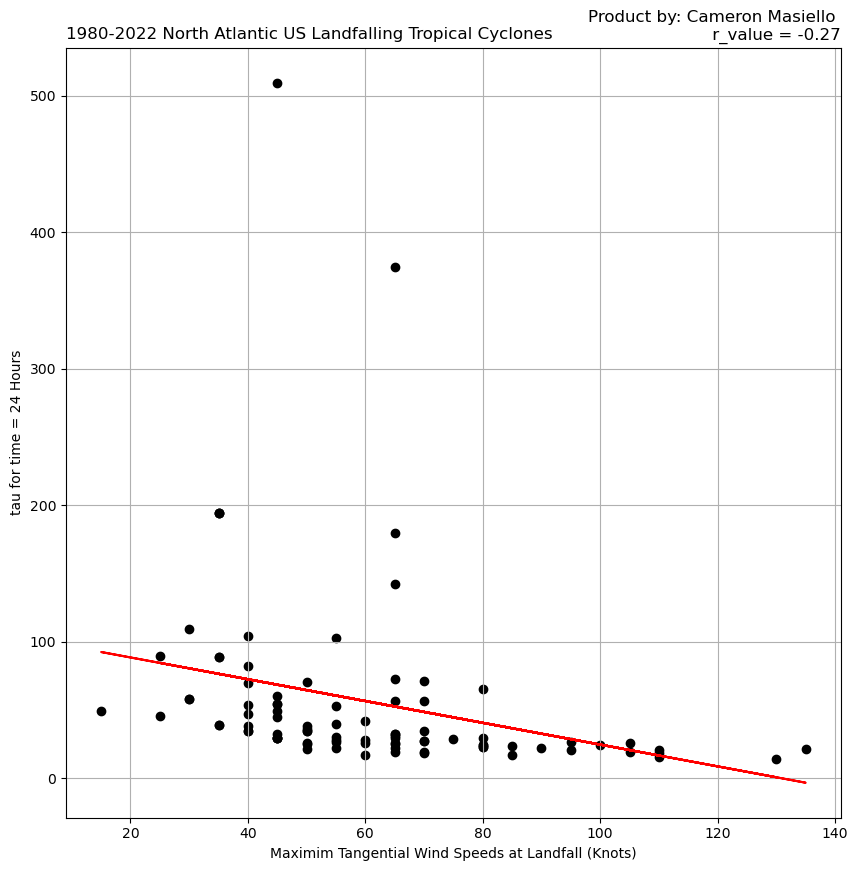

In [121]:

#calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos, all_t_pos)

fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('Maximim Tangential Wind Speeds at Landfall (Knots)')
plt.ylabel('tau for time = 24 Hours')
plt.title('1980-2022 North Atlantic US Landfalling Tropical Cyclones',{"fontsize": 12}, loc = 'left')
plt.title(f'Product by: Cameron Masiello \n r_value = {r_value: .2f}', {"fontsize": 12}, loc = 'right')
#plt.ylim(0,70)

#scatter plot
plt.scatter(all_v_pos, all_t_pos, color = 'black')
#plot the linear regression
regression_line = [slope*xi + intercept for xi in all_v_pos]
plt.plot(all_v_pos, regression_line, color = 'red', label = 'linear_regresssion')


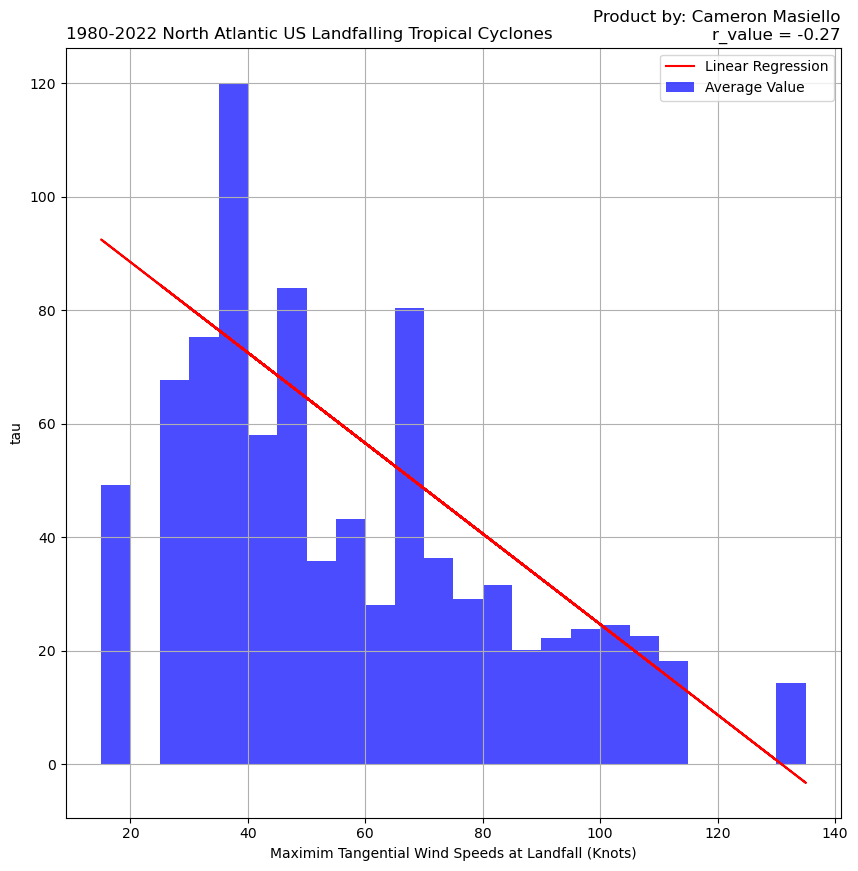

In [122]:
# Your data (all_v_pos and all_t_pos)
# Make sure to define your data before running this code.

# Ensure that all_v_pos is a NumPy array
all_v_pos = np.array(all_v_pos)

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos, all_t_pos)

# Define the bin width
bin_width = 5

# Calculate the number of bins based on the bin width
num_bins = int((max(all_v_pos) - min(all_v_pos)) / bin_width)

# Create bin ranges with increments of 10
bin_ranges = [min(all_v_pos) + i * bin_width for i in range(num_bins)]  # Changed here

# Include the last bin from 130-140
bin_ranges.append(max(all_v_pos))
# Initialize an empty list to store the bin means
bin_means = []

# Calculate the mean values for each bin
for i in range(num_bins):
    mask = (all_v_pos >= bin_ranges[i]) & (all_v_pos < bin_ranges[i+1])
    bin_values = [all_t_pos[j] for j in range(len(mask)) if mask[j]]
    if len(bin_values) > 0:
        bin_mean = np.mean(bin_values)
        bin_means.append(bin_mean)
    else:
        bin_means.append(0.0)  # Handle empty bins

# Create a bar chart
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('Maximim Tangential Wind Speeds at Landfall (Knots)')
plt.ylabel('tau')
plt.title('1980-2022 North Atlantic US Landfalling Tropical Cyclones', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nr_value = {r_value:.2f}', fontsize=12, loc='right')

# Plot the bar chart
plt.bar(bin_ranges[:-1], bin_means, width=bin_width, align='edge', color='blue', alpha=0.7, label='Average Value')

# Plot the linear regression line
regression_line = [slope * xi + intercept for xi in all_v_pos]
plt.plot(all_v_pos, regression_line, color='red', label='Linear Regression')

plt.legend()
plt.show()

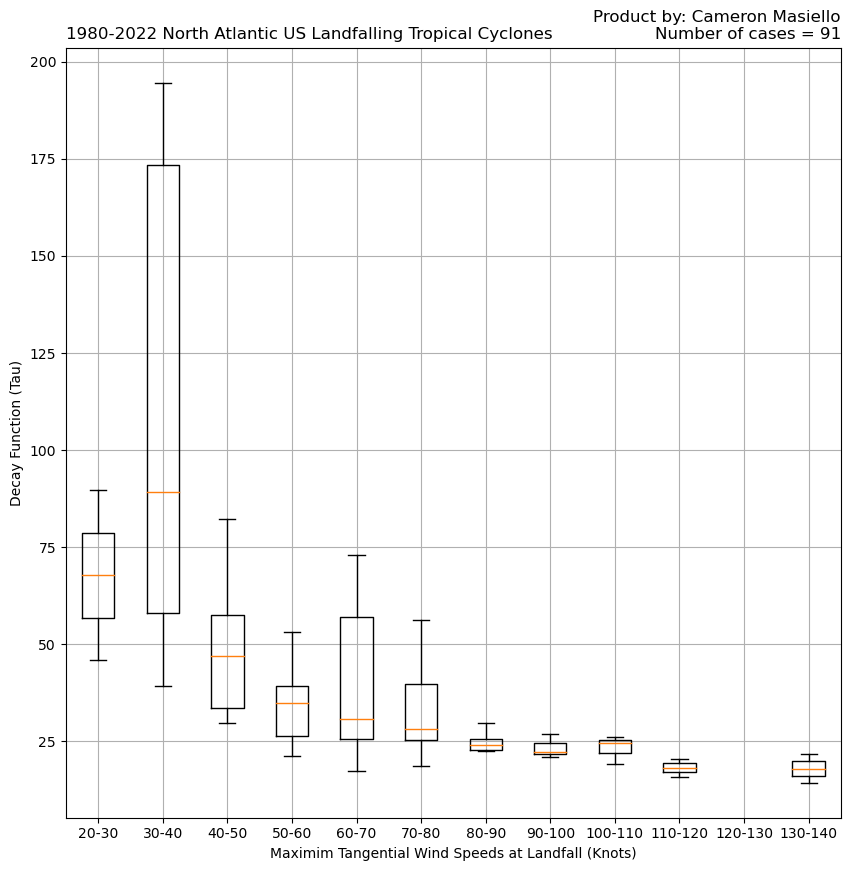

In [127]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Your data (all_v_pos and all_t_pos)
# Make sure to define your data before running this code.

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos, all_t_pos)

# Define the bin width
bin_width = 10

# Calculate the number of bins based on the bin width
num_bins = int((max(all_v_pos) - min(all_v_pos)) / bin_width)

# Create bin ranges with increments of 10
#bin_ranges = [min(all_v_pos) + i * bin_width for i in range(num_bins)]  # Changed here
bin_ranges.append(bin_ranges[-1] + bin_width)  # append an extra bin end

# Include the last bin from 130-140
#bin_ranges.append(max(all_v_pos))

# Initialize an empty list to store the data within each bin
bin_data = []

# Calculate the data within each bin
for i in range(num_bins):
    mask = (all_v_pos >= bin_ranges[i]) & (all_v_pos < bin_ranges[i+1])
    bin_values = [all_t_pos[j] for j in range(len(mask)) if mask[j]]
    bin_data.append(bin_values)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('Maximim Tangential Wind Speeds at Landfall (Knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1980-2022 North Atlantic US Landfalling Tropical Cyclones', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nNumber of cases = {len(all_v_pos)}', fontsize=12, loc='right')

# Plot the box and whisker plots
boxplot = plt.boxplot(bin_data, labels=[f'{bin_ranges[i]:.0f}-{bin_ranges[i+1]:.0f}' for i in range(num_bins)], showfliers=False)

plt.show()